# Liver Model Construction: Notebook-Glycolysis ONLY-trial

## Setup workflow

### Import packages

In [1]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sy
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")

print("MASSpy version: {0}".format(mass.__version__))

import pandas as pd

from six import iteritems

import sympy as sym

import matplotlib.pyplot as plt

from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


In [ ]:
pip install cplex

In [2]:
seed = int(4)
n_models = 1

mass_config = MassConfiguration()
mass_config.solver = "cplex"

## Set paths and constants

### Directory paths

In [3]:
#had to remove the mass
model_dir = os.path.abspath("../models")
maps_dir = os.path.abspath("../maps")

# Create MASS model from COBRA model

### Load COBRA model

In [4]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x026368e7fbe0
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [5]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    #df = df.drop("Fasting Time", axis=1)
    #df = df.drop("Additional Notes", axis=1)
    #df = df.drop("Flux (mmol/(L*hr))", axis=1)
    #df = df.drop("Name", axis=1)
    return df

In [6]:
flux_df = load_data(
    filepath='1.5-ma-data-collection.xlsx',
    sheet_name="Fluxes")
flux_df = flux_df.drop("Fasting Time", axis=1)
flux_df = flux_df.drop("Additional Notes", axis=1)
flux_df = flux_df.drop("Flux (mmol/(L*hr))", axis=1)
flux_df = flux_df.drop("Unnamed: 5", axis=1) ## weird anomaly, shouldn't happen
flux_df = flux_df.drop("Unnamed: 6", axis=1)## weird anomaly, shouldn't happen
flux_df


,Flux(mmol/(gDW*hr))
ID,
GLCter,-0.001674
G6PPer,0.001674
G6Pter,0.001674
GLPASE1,0.000215
PGMT,0.000215
EX_glygn2_c,-0.000215
GAPD,0.002903
PGK,-0.002903
PGM,0.002903


In [7]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
#reverse_flux_percent = 0.1
#irreversible_enzyme_pairs = ["PFK", "FBP"]

In [8]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)

GLCter -0.001674327221
G6PPer 0.001674327221
G6Pter 0.001674327221
GLPASE1 0.0002150512027
PGMT 0.0002150512027
EX_glygn2_c -0.0002150512027
GAPD 0.002903191236
PGK -0.002903191236
PGM 0.002903191236
ENO -0.002903191236
PEPCKm 0.004178137652
PCm 0.003794117647
LDH_L 0.002519171231
ME2 0.0006297928078
PYK 0.0006297928078
CSm 0.002995356037
SUCOASm -0.003379376042
SUCD1m 0.003379376042
FUMm 0.003379376042
MDHm 0.003379376042
EX_lac__L_c 0.001566801619


In [9]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()


In [10]:
# Make adjustments to net flux of PFK/FBP to ensure
# no target flux value is 0 in order to create an enzyme module.
#performing reverse flux percent on computed values rather than measured values like the MASSpy publication
flux_solution.fluxes.FBP = flux_solution.fluxes.PFK * 0.1
flux_solution.fluxes

CSm                0.001376
ACONTm             0.000688
ICDHxm             0.000688
AKGDm              0.000688
SUCOASm           -0.000688
                     ...   
EX_nh4_c           0.000000
EX_so3_c          -0.000000
EX_etoh_c         -0.000000
EX_glyc_3octa_c   -0.000000
EX_fru_c           0.000000
Name: fluxes, Length: 187, dtype: float64

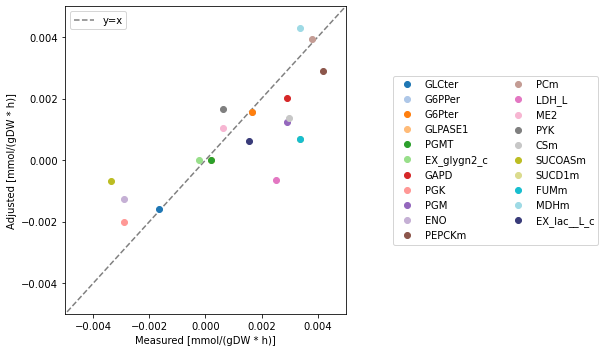

In [11]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux(mmol/(gDW*hr))"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.005,0.005), ylim=(-0.005, 0.005),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


In [12]:
for reaction in core_model.reactions:
    print(reaction.id, reaction.check_mass_balance())


CSm {'charge': -1.0}
ACONTm {}
ICDHxm {}
AKGDm {}
SUCOASm {'charge': 2.0}
SUCD1m {}
FUMm {}
MDHm {'charge': -1.0}
NADH2_u10mi {'charge': 1.0}
FADH2ETC {}
CYOR_u10mi {'charge': -2.0}
CYOOm2i {'charge': 4.0}
ATPS4mi {'charge': -1.0}
Htmi {}
HEX1 {'charge': -1.0}
PGI {}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
ADK1 {}
PDHm {}
LDH_L {'charge': -1.0}
G6PDH2r {'charge': -1.0}
PGL {'charge': -1.0}
GND {}
RPI {}
RPE {}
TKT1 {}
TKT2 {}
TALA {}
PCm {'charge': 1.0}
PEPCKm {}
FBP {'charge': 2.0}
G6PPer {'charge': 2.0}
G6Pter {}
GLCter {}
MALtm {}
MDH {'charge': -1.0}
PEPCK_re {}
PGMT {}
GALUi {'charge': 1.0}
GLGNS1 {'charge': -3.0}
GLBRAN {}
GLPASE1 {'charge': -6.0}
GLDBRAN {}
GLPASE2 {}
GGNG {'charge': -8.0}
ACACT1m {}
HMGCOASm {'charge': 1.0}
HMGLm {}
ADCim {'charge': 1.0}
BDHm {'charge': -1.0}
OCOAT1m {}
NDPK1 {}
NDPK1m {}
NDPK2 {}
HCO3Em {'charge': -1.0}
ATPtm {}
AKGMALtm {}
ASPTA {}
ASPTAm {}
CITtam {}
CITL {}
ME2 {}
ACS {}
ARGN {}
OCBT

## Create MASS model

In [13]:
glycolysis = MassModel("Glycolysis", array_type='DataFrame', dtype=np.int64)
glycolysis

Name,Glycolysis
Memory address,0x0263014c1a90
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [14]:
reaction_list = ['HEX1',
                'PGI',
                'FBP',
                'PFK',
                'FBA',
                'TPI',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
                'PEPtm',
                'PEPCKm',
                'LDH_L',
                'PYK',
                'PCm',
                'PYRt2m']




In [15]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycolysis.add_reactions([MassReaction(reaction)])

In [16]:
glycolysis.reactions.HEX1

Reaction identifier,HEX1
Name,Hexokinase (D-glucose:ATP)
Memory address,0x0263015989d0
Subsystem,Glycolysis/gluconeogenesis
Kinetic Reversibility,True
Stoichiometry,atp_c + glc__D_c <=> adp_c + g6p_c + h_c ATP C10H12N5O13P3 + D-Glucose <=> ADP C10H12N5O10P2 + D-Glucose 6-phosphate + H+
GPR,3098_AT3 or 80201_AT1 or 2645_AT3 or 3098_AT4 or 3099_AT1 or 2645_AT2 or 3098_AT5 or 2645_AT1 or 3098_AT1 or 3101_AT1 or 3098_AT2
Bounds,"(0.0, 1000.0)"


##  Set Fluxes

In [17]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605
    #/ 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 3.2992884001222023
v_PGI: 1.2844120883040366
v_FBP: 0.1284412088304037
v_PFK: 1.2844120883040366
v_FBA: 1.2844120883040366
v_TPI: 1.2844120883040366
v_GAPD: 2.5688241766080733
v_PGK: -2.5688241766080733
v_PGM: 1.6015026930233986
v_ENO: -1.6015026930233986
v_PEPtm: 3.726559657680128
v_PEPCKm: 3.726559657680128
v_LDH_L: -0.8094464970104237
v_PYK: 2.12505696465673
v_PCm: 5.046263621587324
v_PYRt2m: 6.805641301184972


## Set Keqs

In [18]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io='1.5-ma-data-collection.xlsx',
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1)

Keq_df

,Equlibrium Constant
Reaction,
CSm,5.225834e-07
ACONTm,7.157880e-02
ICDHxm,1.331211e-01
AKGDm,4.624549e+04
SUCOASm,1.592564e+00
...,...
EX_nh4_c,NaN
EX_so3_c,NaN
EX_etoh_c,NaN


In [19]:
# Set equilibrium constants
Keq_list =[]
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
        

Keq_HEX1: 2246.155176
Keq_PGI: 0.3509797361
Keq_PFK: 514.5959163
Keq_FBA: 0.0002049897414
Keq_TPI: 8.772406043
Keq_GAPD: 0.6279182855
Keq_PGK: 0.0005001317907
Keq_PGM: 5.726157133
Keq_ENO: 4.364891179
Keq_PYK: 23920.23878
Keq_LDH_L: 6.404569654e-05
Keq_PCm: 13.4
Keq_PEPCKm: 0.005536708019
Keq_FBP: 154.6616914
Keq_PEPtm: 1.0
Keq_PYRt2m: 1.0


In [20]:
len(reaction_list) == len(Keq_list)

True

## Correct Metabolite Identifiers

## Set H2O/H Constants


In [21]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in ["h2o_c", "h_c",'h_i', 'h_m']:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True


## Obtain Concentrations

In [22]:
#Load Concentration Data
conc_df = load_data(
    filepath='1.5-ma-data-collection.xlsx',
    sheet_name="Concentrations")
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)

# Fix identifiers in the dataframe
#conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [23]:
# conc_df.index

In [24]:
#Set Concentrations

metabolite_list = ['glc__D_c',
           'g6p_c',
           'f6p_c',
           'fdp_c',
           'dhap_c',
           'g3p_c',
           '13dpg_c',
           '3pg_c',
            '2pg_c',
            'pep_c',
            'pyr_c',
            'lac__L_c',
           'nad_c',
            'nadh_c',
           'amp_c',
           'adp_c',
            'atp_c',
            'pi_c',
            'h_c',          
            'h2o_c',
            'pep_m',
            'pi_m',
            'co2_m',
            'gdp_m',
            'gtp_m',
            'oaa_m',
            'adp_m',
            'atp_m',
            'h_m',
            'hco3_m',
            'pyr_m',
            'h_i']

m=["amp_c"]
for item in m:
    met = core_model.metabolites.get_by_id(item)
    glycolysis.add_metabolites([MassMetabolite(met)])

In [25]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc
        #/ 1000 #mM --> M
        met_list.append(metabolite.ic)
    
    
    
# For "pi_c", "g3p_c", "lac__D_c" use steady state literature concentrations
# Set h_c and h2o_c to 1 
for metabolite in ['h_i', 'h_m',"h_c", "h2o_c"]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    if metabolite.id in ["h_c", "h2o_c"]:
        metabolite.ic = 1000
    
for metabolite in glycolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))
    


adp_c: 1.99495195
atp_c: 4.72714598
g6p_c: 0.14
glc__D_c: 10.48280703
h_c: 1000
f6p_c: 0.12713765
fdp_c: 0.051470825
h2o_c: 1000
pi_c: 6.4
dhap_c: 0.17689737
g3p_c: 0.00878387
13dpg_c: nan
nad_c: 1.82530972
nadh_c: 0.00463542
3pg_c: 0.520630485
2pg_c: 0.110560855
pep_c: 0.31
pep_m: 2.05
pi_m: 0.45
co2_m: nan
gdp_m: nan
gtp_m: nan
oaa_m: 0.03119
lac__L_c: 3.26183772
pyr_c: 0.48
adp_m: 8.0389058
atp_m: 9.19
h_m: nan
hco3_m: nan
pyr_m: 1.34
h_i: nan
amp_c: 0.365


In [26]:
#convert nan values to None Type
#excluded_metabolites_list = []
#for metabolite in glycolysis.metabolites: 
#    if type(metabolite.ic) == None: 
#        excluded_metabolites_list.append()
#excluded_metabolites_list    

#type(glycolysis.metabolites.pyr_m.ic)


In [27]:
# glycolysis.metabolites.h_i.ic
glycolysis.reactions.list_attr("Keq_str")

['Keq_HEX1',
 'Keq_PGI',
 'Keq_FBP',
 'Keq_PFK',
 'Keq_FBA',
 'Keq_TPI',
 'Keq_GAPD',
 'Keq_PGK',
 'Keq_PGM',
 'Keq_ENO',
 'Keq_PEPtm',
 'Keq_PEPCKm',
 'Keq_LDH_L',
 'Keq_PYK',
 'Keq_PCm',
 'Keq_PYRt2m']

In [28]:
len(metabolite_list) == len(glycolysis.metabolites) == len(met_list)

True

In [29]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    glycolysis,
    excluded_metabolites=['h_i', 'h_m',"h_c", "h2o_c",'13dpg_c','co2_m', 'gdp_m', 'gtp_m', 'hco3_m'],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(glycolysis.fixed))
#     fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution



mass\util\util.py:159 UserWarning: Unrecognized kwargs: ['Keq_percent_deviation']


,variables,reduced_costs
adp_c,1.994952,0.0
atp_c,4.727146,0.0
g6p_c,0.268234,0.0
glc__D_c,10.482807,0.0
f6p_c,0.066357,0.0
...,...,...
Keq_PEPCKm,0.184082,0.0
Keq_LDH_L,0.000064,0.0
Keq_PYK,23920.238780,0.0
Keq_PCm,13.400000,0.0


mass\visualization\visualization_util.py:1269 UserWarning: Ignoring {'thf_c', '13dpg_c', 'acald_m', 'nadp_c', 'h_c', 'orn_c', 'fru_c', 'Tyr_ggn_c', 'gdp_m', 'mal__L_m', 'acACP_c', '3ooctACP_c', 'hco3_m', 'toct2eACP_c', '3hhcoa_m', 'hmgcoa_m', 'ac_c', 'succ_m', 'hx2coa_m', 'fum_m', '3hocoa_m', 'h_i', 'argsuc_c', 'gtp_c', 'thf_m', 'mal__L_c', 'glyc_3octa_c', 'akg_c', '3haACP_c', '3ohcoa_m', 'oc2coa_m', 'hxcoa_m', 'occoa_prod_c', 'glu__L_c', 'acald_c', 'but2eACP_c', 'h2o_r', '3ohexACP_c', 'malACP_c', 'acetone_m', 'fad_m', 'asn__L_c', 'h2o_m', 'glyald_c', 'ficytC_m', 'arg__L_c', 'aacoa_m', 'gly_c', 'glyc_2octa_c', 'oaa_c', 'coa_m', 'cbp_m', 'crn_c', 'fadh2_m', 'g1p_c', 'gln__L_c', '6pgc_c', '3oocoa_m', 'ala__L_c', 'ser__L_c', 'h_m', 'co2_m', 'ac_m', '3hhexACP_c', 'nadp_m', 'o2_m', 'b2coa_m', 'malcoa_c', 'hco3_c', 'cit_c', 'accoa_c', 'utp_c', 'btcoa_m', 'nh4_m', 'akg_m', 'glc__D_r', 'occoa_c', 'crn_m', 'bhb_c', '2amac_c', 'ocACP_c', 'citr__L_c', 'actACP_c', 'dxtrn_c', 'acac_m', 'q10h2_m', '

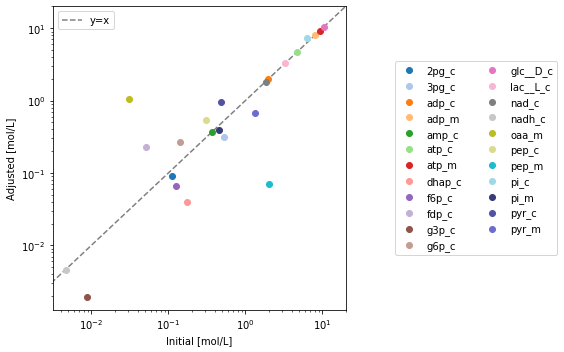

In [30]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (mM)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(0, 20), ylim=(0, 20), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations


In [31]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,fdp_c,pi_c,dhap_c,g3p_c,nad_c,...,pep_c,pep_m,pi_m,oaa_m,lac__L_c,pyr_c,adp_m,atp_m,pyr_m,amp_c
0,4.461286,29.103508,0.963458,38.676244,0.122818,0.115727,6.286298,0.023618,0.00053,6.876521,...,0.070769,0.065896,1.023699,0.973067,1.607367,0.714967,2.941692,47.589148,0.075842,0.040006


## Set concentrations and balance models with pseudoreactions


In [ ]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)
        
        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

In [51]:
# Determine imbalances in the reduced network
fluxes = np.array(list(glycolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0:
        continue
    # Get metabolite object
    met = glycolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
        glycolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycolysis.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

## QC/QA

In [52]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)


╒══════════════════════════════════════════╕
│ MODEL ID: Glycolysis                     │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [53]:
## balancing charges on reactions manually

glycolysis.metabolites.h_c.charge=1
glycolysis.metabolites.h_m.charge=1
glycolysis.metabolites.h_i.charge=1
glycolysis.metabolites.pi_c.charge=-2
glycolysis.metabolites.pi_m.charge=-2


In [54]:
glycolysis.calculate_PERCs(update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))


ValueError: Must be a non-negative number

In [50]:
glycolysis.reactions.PGK

Reaction identifier,PGK
Name,Phosphoglycerate kinase
Memory address,0x0263015a0610
Subsystem,Glycolysis/gluconeogenesis
Kinetic Reversibility,True
Stoichiometry,"3pg_c + atp_c <=> 13dpg_c + adp_c 3-Phospho-D-glycerate/ 3- Phosphoglycerate + ATP C10H12N5O13P3 <=> 3-Phospho-D-glyceroyl phosphate/ 1,3 Bisphosphoglycer ate + ADP C10H12N5O10P2"
GPR,5230_AT1 or 375056_AT1 or 5232_AT1
Bounds,"(-1000.0, 1000.0)"


## Simulate Glycolysis

In [55]:
tfinal = 1e4
verbose = False

sim = Simulation(glycolysis, verbose=False)


# Setup simulation object
#sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
#conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
#conc_sol.view_time_profile()


ERROR: Error encountered trying to  <set specie id for '13dpg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie id for '3pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie id for '2pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved

ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie reference id for '2pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie reference id for '3pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a 

MassSimulationError: Could not load MassModel 'Glycolysis'

## Ensure model is in steady state and export

In [ ]:
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4
verbose = False

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

In [ ]:
## Adding additional reactions
ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)

ADK = ['amp_c','atp_c']
for i in ADK:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:1})
    
ADP =['adp_c']
for i in ADP:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:-2})


In [ ]:
ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)

ATPM_1 = ['atp_c', 'h2o_c']
ATPM_2= ['adp_c','h_c','pi_c']

for i in ATPM_1:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:-1})
    

for i in ATPM_2:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:1})



In [ ]:
DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)

DM_nadh_1 = ['nadh_c']
DM_nadh_2= ['nad_c','h_c']

for i in DM_nadh_1:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:-1})
    

for i in DM_nadh_2:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:1})



In [ ]:
# Add new reactions
glycolysis.add_reactions([ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

### View extracted network

In [ ]:
### NEED TO CHECK!!
escher_builder = escher.Builder(
    model=glycolysis,
    map_json=os.path.join(
        maps_dir, ".".join((
            glycolysis.id, "map", "json"))
    ),
    highlight_missing=True)

escher_builder

### Boundary Reactions

In [ ]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('glc__D_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)


SK_lac__L_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('lac__L_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('pyr_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h2o_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)



DM_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

## Simulate at steady state

In [ ]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

# Export MASS model

In [ ]:
save_json_mass_model(
    mass_model=glycolysis,
    filename=os.path.join(model_dir, glycolysis.id + ".json"))